# Word Embedding Analysis

https://medium.com/@Suraj_Yadav/understanding-intra-cluster-distance-inter-cluster-distance-and-dun-index-a-comprehensive-guide-a8de726f5769

## load data

In [26]:
import pandas as pd, numpy as np
import glob
from tqdm import tqdm

import json
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [3]:
df_word_embedding = pd.read_parquet('./data/headlines/headlines_unique_Jan_Feb.parquet')
df_word_embedding

,url,headline,datePublished_site,probability,date_collected,siteName,NE,embedding
0,https://nypost.com/2024/01/23/lifestyle/couple...,Couple demanding child get free upgrade to fir...,None,0.892056,2024-01-23,NewYorkPost(News),[Coup],"[-0.037742957, -0.007708069, 0.004684645, -0.0..."
1,https://nypost.com/2024/01/23/entertainment/ka...,"Kate Middleton FaceTimes her kids George, Char...",None,0.892016,2024-01-23,NewYorkPost(News),"[Kate Middleton, George, Charlotte, Louis]","[-0.018179407, -0.0136436755, -0.017765962, -0..."
2,https://nypost.com/2024/01/23/entertainment/os...,2024 Oscar nominations announced: See the full...,None,0.903449,2024-01-23,NewYorkPost(News),[Oscar],"[-0.018472563, 0.031687282, -0.019757815, 0.00..."
3,https://nypost.com/2024/01/23/news/hunter-bide...,Hunter Biden's 'sugar brother' side steps ques...,None,0.922552,2024-01-23,NewYorkPost(News),"[Hunter Biden, Biden, Joe]","[0.043067176, 0.004102276, -0.020094428, 0.015..."
4,https://nypost.com/2024/01/23/lifestyle/a-bill...,A billionaire is paying my NYC rent for 3 mont...,None,0.907059,2024-01-23,NewYorkPost(News),[NYC],"[0.029510427, -0.03090462, -0.008285285, -0.01..."
...,...,...,...,...,...,...,...,...
267631,https://www.usatoday.com/story/news/world/2024...,New study says fish discovered 3 years ago can...,None,0.763477,2024-02-29,USATODAY,[],"[-0.019353423, -0.0029539436, -0.0129284, -0.0..."
267632,https://www.usatoday.com/story/entertainment/t...,"Black astronaut Ed Dwight, reflects on 'The Sp...",None,0.722521,2024-02-29,USATODAY,"[Black, Ed Dwight, The, Space Race]","[-0.00038863573, -0.021946488, -0.021370115, -..."
267633,https://www.usatoday.com/story/news/nation/202...,"'Life-threatening' conditions, up to 10 feet o...",None,0.685995,2024-02-29,USATODAY,[],"[-0.01681874, -0.009240714, -0.002482043, 0.02..."
267634,https://www.usatoday.com/videos/news/politics/...,"Biden, Trump visit US-Mexico border on same day",None,0.448134,2024-02-29,USATODAY,"[Biden, Trump, US, Mexico]","[0.017860102, 0.00048904907, -0.012666605, -0...."


In [4]:
# convert datetime, only need for the raw data
# df_word_embedding["date_collected"] = df_word_embedding.apply(lambda x : datetime.strptime(x["date_collected"][:8], "%Y%m%d"), axis = 1)

In [9]:
file_path = './data/site_leanings.json'

# Loading the JSON content
with open(file_path, 'r') as file:
    left_or_right = json.load(file)

In [10]:
tqdm.pandas()
df_word_embedding["leaning"] = df_word_embedding.progress_apply(lambda x : left_or_right[x["siteName"]], axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267636/267636 [00:02<00:00, 100179.33it/s]


In [11]:
df_word_embedding.memory_usage(deep=True).sum() / (1024 ** 2)

188.62172889709473

In [12]:
df_word_embedding

,url,headline,datePublished_site,probability,date_collected,siteName,NE,embedding,leaning
0,https://nypost.com/2024/01/23/lifestyle/couple...,Couple demanding child get free upgrade to fir...,None,0.892056,2024-01-23,NewYorkPost(News),[Coup],"[-0.037742957, -0.007708069, 0.004684645, -0.0...",right
1,https://nypost.com/2024/01/23/entertainment/ka...,"Kate Middleton FaceTimes her kids George, Char...",None,0.892016,2024-01-23,NewYorkPost(News),"[Kate Middleton, George, Charlotte, Louis]","[-0.018179407, -0.0136436755, -0.017765962, -0...",right
2,https://nypost.com/2024/01/23/entertainment/os...,2024 Oscar nominations announced: See the full...,None,0.903449,2024-01-23,NewYorkPost(News),[Oscar],"[-0.018472563, 0.031687282, -0.019757815, 0.00...",right
3,https://nypost.com/2024/01/23/news/hunter-bide...,Hunter Biden's 'sugar brother' side steps ques...,None,0.922552,2024-01-23,NewYorkPost(News),"[Hunter Biden, Biden, Joe]","[0.043067176, 0.004102276, -0.020094428, 0.015...",right
4,https://nypost.com/2024/01/23/lifestyle/a-bill...,A billionaire is paying my NYC rent for 3 mont...,None,0.907059,2024-01-23,NewYorkPost(News),[NYC],"[0.029510427, -0.03090462, -0.008285285, -0.01...",right
...,...,...,...,...,...,...,...,...,...
267631,https://www.usatoday.com/story/news/world/2024...,New study says fish discovered 3 years ago can...,None,0.763477,2024-02-29,USATODAY,[],"[-0.019353423, -0.0029539436, -0.0129284, -0.0...",left
267632,https://www.usatoday.com/story/entertainment/t...,"Black astronaut Ed Dwight, reflects on 'The Sp...",None,0.722521,2024-02-29,USATODAY,"[Black, Ed Dwight, The, Space Race]","[-0.00038863573, -0.021946488, -0.021370115, -...",left
267633,https://www.usatoday.com/story/news/nation/202...,"'Life-threatening' conditions, up to 10 feet o...",None,0.685995,2024-02-29,USATODAY,[],"[-0.01681874, -0.009240714, -0.002482043, 0.02...",left
267634,https://www.usatoday.com/videos/news/politics/...,"Biden, Trump visit US-Mexico border on same day",None,0.448134,2024-02-29,USATODAY,"[Biden, Trump, US, Mexico]","[0.017860102, 0.00048904907, -0.012666605, -0....",left


## Good/bad Antonyms

In [54]:
# read data
df_good_bad = pd.read_parquet("./data/df_good_bad.parquet")

In [55]:
df_good_bad

,good_word,good_embedding,bad_word,bad_embedding
0,good,"[0.004305769689381123, -0.004893989767879248, ...",bad,"[-0.014306066557765007, 0.009409538470208645, ..."
1,best,"[0.008746912702918053, 0.03367193415760994, -0...",worst,"[-0.022390739992260933, 0.035692859441041946, ..."
2,fine,"[-0.0010375342098996043, 0.0039906795136630535...",deficient,"[0.016590019688010216, 0.03946790471673012, -0..."
3,superior,"[0.02638305351138115, 0.004405620042234659, -0...",inferior,"[-0.017175743356347084, 0.0025245025753974915,..."
4,satisfactory,"[0.028946034610271454, 0.037752605974674225, -...",unsatisfactory,"[0.028165165334939957, 0.017635727301239967, -..."
5,acceptable,"[-0.004314293619245291, 0.03673477843403816, -...",unacceptable,"[-0.00701149133965373, -0.01975487731397152, -..."
6,excellent,"[-0.0028321566060185432, 0.009339209645986557,...",awful,"[-0.026952287182211876, -0.0062140957452356815..."
7,superb,"[0.05479724332690239, 0.016285769641399384, -0...",terrible,"[-0.02064591273665428, -0.002998895011842251, ..."
8,outstanding,"[0.018081525340676308, 0.02422449178993702, -0...",dreadful,"[-0.009716781787574291, 0.010948600247502327, ..."
9,exceptional,"[0.00447204289957881, 0.02894514426589012, -0....",unexceptional,"[0.001000346033833921, 0.01961054652929306, -0..."


In [56]:
good_bad_dimension = np.mean(df_good_bad["good_embedding"]) - np.mean(df_good_bad["bad_embedding"])

In [57]:
good_bad_dimension

array([ 0.02099921,  0.00841344, -0.0051291 , ..., -0.00711416,
       -0.00103793,  0.00046543])

In [81]:
for x in df_good_bad["bad_word"]:
    print(x)

bad
worst
deficient
inferior
unsatisfactory
unacceptable
awful
terrible
dreadful
unexceptional


# Antonyms Comparsion

## Comparision between Clusters

### load antonyms

In [13]:
from util import *

In [14]:
df_antonyms = pd.read_parquet("data/df_antonyms.parquet")
df_antonyms

,adj_1,adj_2,adj_1_embedding,adj_2_embedding
0,comparable,incomparable,"[-0.019301222637295723, 0.011061019264161587, ...","[0.012978984974324703, -0.0027543564792722464,..."
1,proved,unproved,"[0.016204241663217545, 0.016003673896193504, -...","[0.015760842710733414, 0.0006610580021515489, ..."
2,fatty,nonfat,"[-0.006109761074185371, 0.018375856801867485, ...","[-0.0030756292399019003, 0.006370946299284697,..."
3,disposable,nondisposable,"[-0.06539838016033173, 0.002771256258711219, 0...","[-0.046912819147109985, -0.0005513812648132443..."
4,shrinkable,unshrinkable,"[-0.019847901538014412, -0.008843732997775078,...","[-0.001083246199414134, -0.022068507969379425,..."
...,...,...,...,...
1823,appealing,unappealing,"[-0.00962099339812994, 0.022533150389790535, -...","[-0.006122448015958071, -0.01592993177473545, ..."
1824,precocious,retarded,"[0.009357798844575882, 0.02012326754629612, -0...","[-0.008591502904891968, 0.004101067315787077, ..."
1825,breathing,breathless,"[-0.0037388750351965427, 0.01762058027088642, ...","[0.004579761065542698, 0.022734813392162323, 0..."
1826,analogue,digital,"[-0.026716582477092743, -0.009638152085244656,...","[-0.01176784373819828, 0.012267342768609524, -..."


### Compare between left and right media, all headlines included

In [15]:
def get_left_to_right_vec(df):
    centroids = {}
    for group_name, group_df in df.groupby('leaning'):
        # Drop the 'group' column to only include embedding dimensions
        group_df = group_df.drop('leaning', axis=1)
        
        # Calculate centroid for the current group
        centroid = cluster_centroid(group_df["embedding"])
        
        # Store the centroid using the group name as the key
        centroids[group_name] = centroid

    left_to_right_vec = centroids["right"] - centroids["left"]
    return left_to_right_vec

def calc_scale_leaning_similarity_df(df_word_embedding, df_antonyms, good_bad_dimension):
    left_to_right_vec = get_left_to_right_vec(df_word_embedding)
    result = []
    for x in df_antonyms.apply(lambda x : [x["adj_1"], x["adj_2"], get_cos_similiarity(x["adj_1_embedding"] - x["adj_2_embedding"], left_to_right_vec), \
                                           abs(get_cos_similiarity(x["adj_1_embedding"] - x["adj_2_embedding"], good_bad_dimension))], axis = 1):
        # left adj, right_adj, dimension similarity to the distance between right and left, dimension similarity to good/bad dimension
        if x[2] > 0:
            # reverese the order according to the direction of the dimension
            result.append([x[1], x[0], abs(x[2]), x[3]])
        else:
            result.append([x[0], x[1], abs(x[2]), x[3]])
    

    return pd.DataFrame(result, columns = ["Left_adj", "Right_adj", "scale_leaning_similarity", "scale_good_bad_similiarity"])

In [21]:
# no general pattern
df_left_right_result = calc_scale_leaning_similarity_df(df_word_embedding, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)

In [22]:
df_left_right_result.head(30)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
1246,topped,topless,0.154941,0.095598
74,unexploited,exploited,0.153948,0.040194
505,nonalcoholic,alcoholic,0.145844,0.057500
603,modest,immodest,0.129883,0.228343
283,concentric,eccentric,0.129735,0.027570
103,nonwoody,woody,0.128246,0.105616
515,publishable,unpublishable,0.127214,0.300004
812,bloodless,bloody,0.124714,0.008098
917,orderly,disorderly,0.123073,0.309361
393,forehand,backhand,0.120625,0.061618


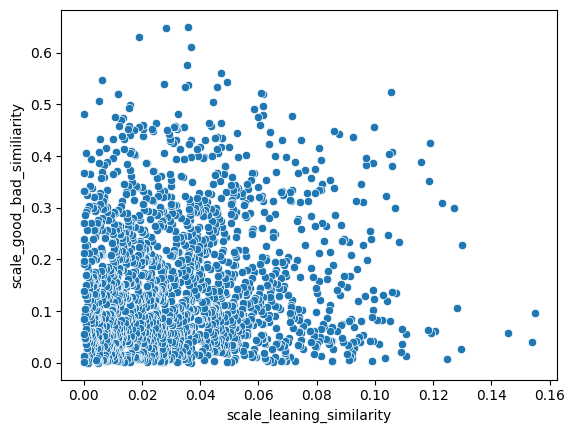

In [24]:
# Plotting
sns.scatterplot(data=df_left_right_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [27]:
# # Pearson's R
# pearson_coefficient, p_value = pearsonr(df_left_right_result['scale_good_bad_similiarity'], df_left_right_result['scale_leaning_similarity'])
# print(f"Pearson's R (using scipy.stats): {pearson_coefficient}, P-value: {p_value}")

# Calculate Spearman's rank correlation
rho, p_value = spearmanr(df_left_right_result['scale_good_bad_similiarity'], df_left_right_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")


Spearman's rank correlation coefficient: 0.03370445966865227
P-value: 0.14973683413810995


## Comparision between Biden and Trump related Terms

In [29]:
def filter_df_by_NE(df, NE):
    # filiter df to include rows with at least one named entity in the list NE
    filtered_df = df[df['NE'].apply(lambda x: len(set(x) & set(NE)) > 0)]
    return filtered_df

df_biden = filter_df_by_NE(df_word_embedding, ["Biden", "Joe Biden"])
df_biden_result = calc_scale_leaning_similarity_df(df_biden, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)

In [31]:
df_biden_result.head(10)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
264,supportive,unsupportive,0.217544,0.449561
80,hopeful,hopeless,0.200252,0.357643
323,employable,unemployable,0.196274,0.388458
1717,respectful,disrespectful,0.194835,0.408849
880,tactful,tactless,0.193843,0.404128
991,seaworthy,unseaworthy,0.190906,0.523857
1483,considerate,inconsiderate,0.187947,0.382445
1627,playable,unplayable,0.185498,0.417247
1707,pro-American,anti-American,0.184464,0.354263
603,modest,immodest,0.183473,0.228343


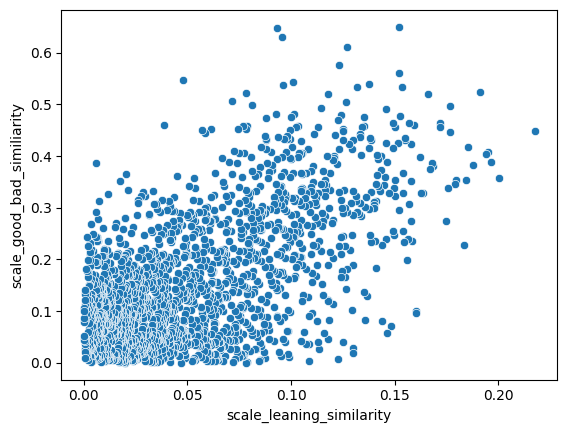

In [32]:
# Plotting
sns.scatterplot(data=df_biden_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [33]:
# Pearson's R
pearson_coefficient, p_value = pearsonr(df_biden_result['scale_good_bad_similiarity'], df_biden_result['scale_leaning_similarity'])
print(f"Pearson's R (using scipy.stats): {pearson_coefficient}, P-value: {p_value}")

Pearson's R (using scipy.stats): 0.5920766353696297, P-value: 2.2369763993824918e-173


In [34]:
# Spearman's rank
rho, p_value = spearmanr(df_biden_result['scale_good_bad_similiarity'], df_biden_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.48989143421026077
P-value: 5.8401093758799966e-111


In [35]:
# Trump result
df_trump = filter_df_by_NE(df_word_embedding, ["Trump", "Donald Trump"])
df_trump_result = calc_scale_leaning_similarity_df(df_trump, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)

In [37]:
df_trump_result.head(10)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
835,substantive,adjective,0.149455,0.042361
1024,stoppable,unstoppable,0.120541,0.011126
971,unowned,owned,0.118999,0.168544
625,nonbearing,bearing,0.113781,0.148135
94,hearing,deaf,0.111707,0.129156
873,endothermic,exothermic,0.110599,0.004128
1581,unobvious,obvious,0.110554,0.041473
1621,atomistic,holistic,0.110260,0.079702
1443,unmade,made,0.107712,0.213323
1289,uncoated,coated,0.104946,0.167304


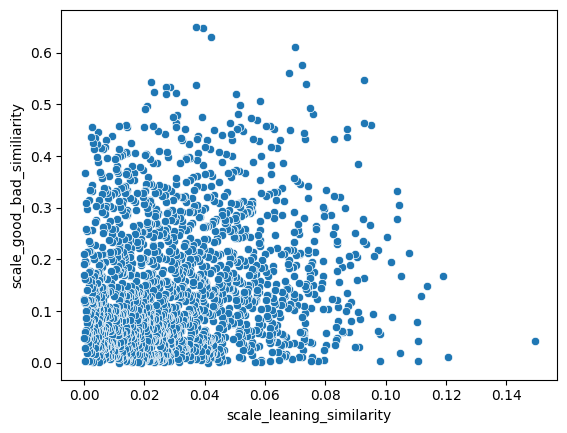

In [38]:
# Plotting
sns.scatterplot(data=df_trump_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [124]:
# Pearson's R
pearson_coefficient, p_value = pearsonr(df_trump_result['scale_good_bad_similiarity'], df_trump_result['scale_leaning_similarity'])
print(f"Pearson's R (using scipy.stats): {pearson_coefficient}, P-value: {p_value}")

Pearson's R (using scipy.stats): 0.10335432107687068, P-value: 9.521434494601135e-06


In [39]:
# Spearman's rank
rho, p_value = spearmanr(df_trump_result['scale_good_bad_similiarity'], df_trump_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.11228457124722419
P-value: 1.4891788929819712e-06


## Comparision between Democrats and Republican related Terms

In [40]:
file_path = './data/dem_rep_NEs.json'

with open(file_path, 'r') as file:
    dem_or_rep = json.load(file)

In [41]:
df_dem = filter_df_by_NE(df_word_embedding,dem_or_rep["Dem"])
df_dem_result = calc_scale_leaning_similarity_df(df_dem, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)
df_dem_result.head(10)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
264,supportive,unsupportive,0.183994,0.449561
80,hopeful,hopeless,0.180730,0.357643
603,modest,immodest,0.173465,0.228343
1717,respectful,disrespectful,0.172078,0.408849
323,employable,unemployable,0.170934,0.388458
880,tactful,tactless,0.165690,0.404128
991,seaworthy,unseaworthy,0.165169,0.523857
463,grateful,ungrateful,0.158162,0.352828
1726,respectable,unrespectable,0.158034,0.456394
1459,constructive,destructive,0.158027,0.274039


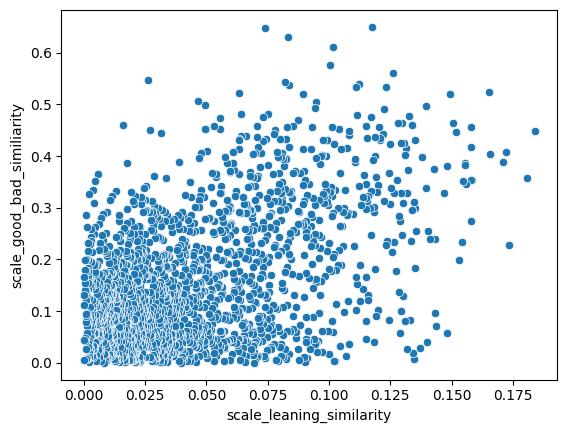

In [42]:
# Plotting
sns.scatterplot(data=df_dem_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [132]:
# Pearson's R
pearson_coefficient, p_value = pearsonr(df_dem_result['scale_good_bad_similiarity'], df_dem_result['scale_leaning_similarity'])
print(f"Pearson's R (using scipy.stats): {pearson_coefficient}, P-value: {p_value}")

Pearson's R (using scipy.stats): 0.4676987920073713, P-value: 5.267399592809987e-100


In [43]:
# Spearman's rank
rho, p_value = spearmanr(df_dem_result['scale_good_bad_similiarity'], df_dem_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.3681301433733732
P-value: 9.140846920178839e-60


In [45]:
df_rep = filter_df_by_NE(df_word_embedding,dem_or_rep["Rep"])
df_rep_result = calc_scale_leaning_similarity_df(df_rep, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)
df_rep_result.head(30)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
835,substantive,adjective,0.155476,0.042361
625,nonbearing,bearing,0.124878,0.148135
1812,nonrepresentative,representative,0.122779,0.278826
971,unowned,owned,0.122348,0.168544
1621,atomistic,holistic,0.120176,0.079702
1581,unobvious,obvious,0.118718,0.041473
1748,nonpartisan,partisan,0.115757,0.088050
1289,uncoated,coated,0.115633,0.167304
1024,stoppable,unstoppable,0.115499,0.011126
1443,unmade,made,0.115161,0.213323


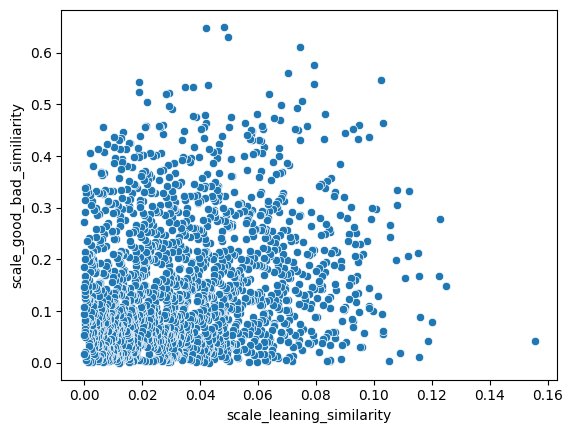

In [46]:
# Plotting
sns.scatterplot(data=df_rep_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [47]:
# Pearson's R
pearson_coefficient, p_value = pearsonr(df_rep_result['scale_good_bad_similiarity'], df_rep_result['scale_leaning_similarity'])
print(f"Pearson's R (using scipy.stats): {pearson_coefficient}, P-value: {p_value}")

Pearson's R (using scipy.stats): 0.14771587815624995, P-value: 2.2079549214649212e-10


In [48]:
# Spearman's rank
rho, p_value = spearmanr(df_rep_result['scale_good_bad_similiarity'], df_rep_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.15649695963521154
P-value: 1.7205447304725166e-11


In [26]:
# antonyms may lack context
# corr with Democrats are significantly weaker than

### Other figures

In [41]:
# Sample DataFrame creation
np.random.seed(42)  # For reproducible output

# Function to sample n_samples from each group
def sample_n_from_group(df, n_samples):
    sampled_df = df.groupby('leaning').apply(lambda x : x.sample(n=n_samples, replace=True)).reset_index(drop=True)
    return sampled_df

In [42]:
sample_n_from_group(df_Haley, 100)

/tmp/ipykernel_106178/1785357269.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('leaning').apply(lambda x : x.sample(n=n_samples, replace=True)).reset_index(drop=True)


,url,headline,datePublished_site,probability,date_collected,siteName,NE,embedding,leaning
0,https://thehill.com/homenews/campaign/4434686-...,Haley dismisses SC endorsements for Trump: ‘Yo...,None,0.730285,2024-01-28,TheHill,"[Haley, SC, Trump]","[0.023159081, -0.045888543, -0.021292929, -0.0...",center
1,https://thehill.com/homenews/campaign/4418233-...,Haley calls out Trump on false claims about Ne...,2024-01-19T14:35:00-05:00,0.983203,2024-01-19,TheHill,"[Haley, Trump, New Hampshire]","[0.01650341, -0.026753427, -0.018798003, -0.02...",center
2,https://thehill.com/homenews/campaign/4390431-...,DeSantis appears to jab Haley by giving CNN an...,2024-01-05T02:57:16.149264,0.666339,2024-01-04,TheHill,"[DeSanti, Haley, CNN, Iowa]","[-0.0051982147, -0.019941136, -0.026498051, -0...",center
3,https://thehill.com/homenews/campaign/4435118-...,Haley defends verdict against Trump in Carroll...,2024-01-29T07:35:00-05:00,0.983575,2024-01-29,TheHill,"[Haley, Trump, Carroll]","[0.040384267, -0.023268428, -0.02491418, -0.00...",center
4,None,Donald Trump and Nikki Haley's Chances in Sout...,2024-01-25T00:00:00,0.351000,2024-01-25,Newsweek,"[Donald Trump, Nikki Haley, Chance, South Caro...","[0.003954346, -0.046195626, -0.021976799, 0.00...",center
...,...,...,...,...,...,...,...,...,...
295,https://www.foxnews.com/media/desantis-wouldnt...,DeSantis says he wouldn't accept role as Nikki...,None,0.944216,2024-01-06,FoxNews(OnlineNews),"[DeSantis, Nikki Haley]","[0.0087774, -0.0379692, -0.00937315, -0.006558...",right
296,https://www.foxnews.com/video/5614615980001,Nikki Haley swiftly loses home state in South ...,None,0.966399,2024-02-24,FoxNews(OnlineNews),"[Nikki Haley, South Carolina]","[0.0041270955, -0.0515003, -0.0031943843, -0.0...",right
297,https://www.breitbart.com/politics/2024/01/02/...,Nikki Haley Tries to Bully Trump into Particip...,None,0.944960,2024-01-02,BreitbartNews,"[Nikki Haley, Trump, CNN Debate]","[-0.010216404, -0.07572236, -0.017827192, -0.0...",right
298,https://www.dailymail.co.uk/news/article-12990...,'That is the sound of a two-person race': Nikk...,None,0.351000,2024-01-22,DailyMail,"[Nikki Haley, Ron DeSantis, White House, New H...","[0.025603542, -0.062353633, -0.018717265, -0.0...",right


In [43]:
Haley_NEs = ["Haley", "Nikki Haley"]

df_Haley = filter_df_by_NE(df_word_embedding, Haley_NEs)
df_Haley = sample_n_from_group(df_Haley, 100)
calc_scale_leaning_similarity_df(df_Haley, df_antonyms).sort_values(by='scale_leaning_similarity', ascending=False).head(30)

/tmp/ipykernel_106178/1785357269.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('leaning').apply(lambda x : x.sample(n=n_samples, replace=True)).reset_index(drop=True)


,Left_adj,Right_adj,scale_leaning_similarity
452,unfortunate,fortunate,0.127046
841,undeclared,declared,0.126955
687,unfinished,finished,0.125646
1581,unobvious,obvious,0.120649
955,inglorious,glorious,0.116648
1692,unsolved,solved,0.107224
853,subordinate,dominant,0.106990
1797,sorrowful,joyful,0.106091
1535,stingy,generous,0.104472
1113,unfilled,filled,0.103055


In [44]:
Carroll_NEs = ["Carroll", "Jean Carroll"]

df_Carroll = filter_df_by_NE(df_word_embedding, Carroll_NEs)
df_Carroll = sample_n_from_group(df_Carroll, 100)
calc_scale_leaning_similarity_df(df_Carroll, df_antonyms).sort_values(by='scale_leaning_similarity', ascending=False).head(30)

/tmp/ipykernel_106178/1785357269.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('leaning').apply(lambda x : x.sample(n=n_samples, replace=True)).reset_index(drop=True)


,Left_adj,Right_adj,scale_leaning_similarity
885,unargumentative,argumentative,0.143411
1781,diffident,confident,0.141213
432,unexpansive,expansive,0.137762
579,noneffervescent,effervescent,0.121835
539,unexcited,excited,0.116494
891,unendowed,endowed,0.114275
889,provincial,cosmopolitan,0.113915
380,unenthusiastic,enthusiastic,0.113792
239,inconspicuous,conspicuous,0.111089
1490,unrigged,rigged,0.106709


In [36]:
df_Carroll_sample = []

for x in df_Carroll.groupby("leaning")

## Word Embedding Trend

In [194]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

In [151]:
print("Biden dot mean: " + str(np.dot(df_biden_result["scale_leaning_similarity"], df_biden_result["scale_good_bad_similiarity"])))
print("Trump dot mean: " + str(np.dot(df_trump_result["scale_leaning_similarity"], df_trump_result["scale_good_bad_similiarity"])))
print("Dem dot mean: " + str(np.dot(df_dem_result["scale_leaning_similarity"], df_dem_result["scale_good_bad_similiarity"])))
print("Rep dot mean: " + str(np.dot(df_rep_result["scale_leaning_similarity"], df_rep_result["scale_good_bad_similiarity"])))

Biden dot mean: 21.121257607496325
Trump dot mean: 10.11950725323949
Dem dot mean: 17.36501772952176
Rep dot mean: 11.554328081004874


In [1]:
print("Biden dot mean: " + str(np.dot(df_biden_result["scale_leaning_similarity"], -df_biden_result["scale_good_bad_similiarity"])))
print("Trump dot mean: " + str(np.dot(df_trump_result["scale_leaning_similarity"], df_trump_result["scale_good_bad_similiarity"])))
print("Dem dot mean: " + str(np.dot(df_dem_result["scale_leaning_similarity"], df_dem_result["scale_good_bad_similiarity"])))
print("Rep dot mean: " + str(np.dot(df_rep_result["scale_leaning_similarity"], df_rep_result["scale_good_bad_similiarity"])))

NameError: name 'np' is not defined

In [176]:
def get_dot_simalirty_by_date(df, df_antonyms, good_bad_dimension):
    df_grouped = df.groupby("date_collected")

    dot_simalirty = []
    for name, group in tqdm(df_grouped):
        dimension_simalirty_day = calc_scale_leaning_similarity_df(group, df_antonyms, good_bad_dimension)
        dot_simalirty_day = np.dot(dimension_simalirty_day["scale_leaning_similarity"], dimension_simalirty_day["scale_good_bad_similiarity"])
        dot_simalirty.append((name,dot_simalirty_day))
    return dot_simalirty

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.75it/s]


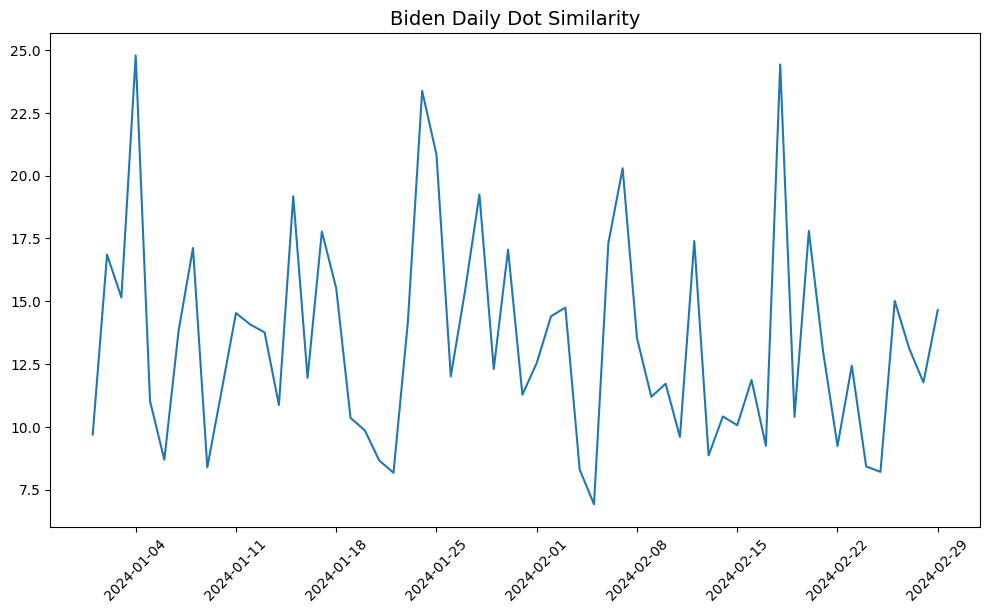

In [200]:
# Format the x-axis to display dates in 'YYYY-MM-DD' format, get x label
def get_daily_trend(result_list, title):
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x = [x[0] for x in result_list], y = [x[1] for x in result_list])
    
    # Set x-axis to only show a label every 7 days
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Show a tick every 7 days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date
    
    plt.xticks(rotation=45)  # Rotate labels to avoid overlap
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

    plt.title(title, fontsize=14)
    plt.show()

biden_daily_similarity = get_dot_simalirty_by_date(df_biden, df_antonyms, good_bad_dimension)
get_daily_trend(biden_daily_similarity, "Biden Daily Dot Similarity")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  7.38it/s]


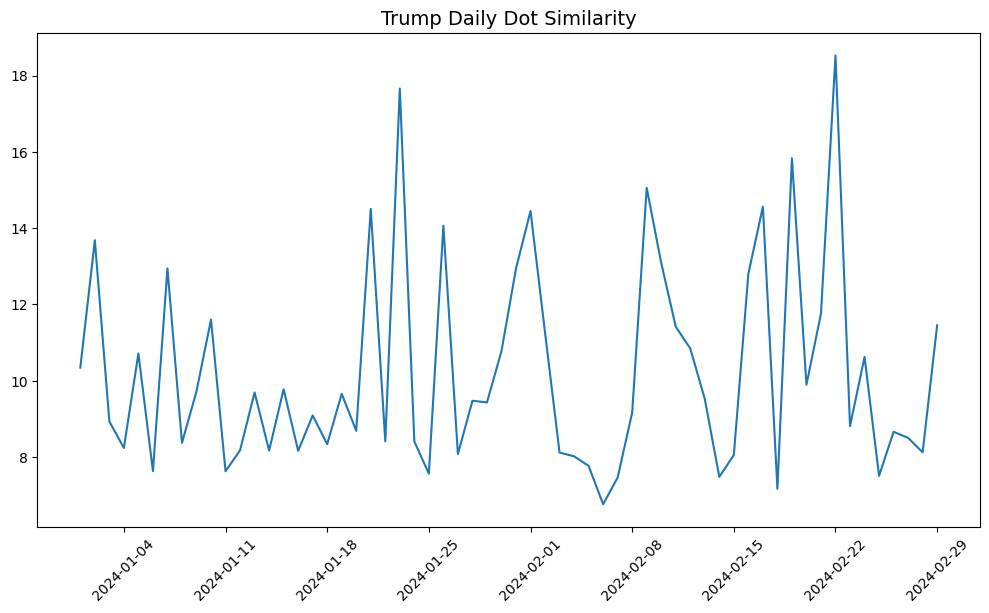

In [202]:
trump_daily_similarity = get_dot_simalirty_by_date(df_trump, df_antonyms, good_bad_dimension)
get_daily_trend(trump_daily_similarity,  "Trump Daily Dot Similarity")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.76it/s]


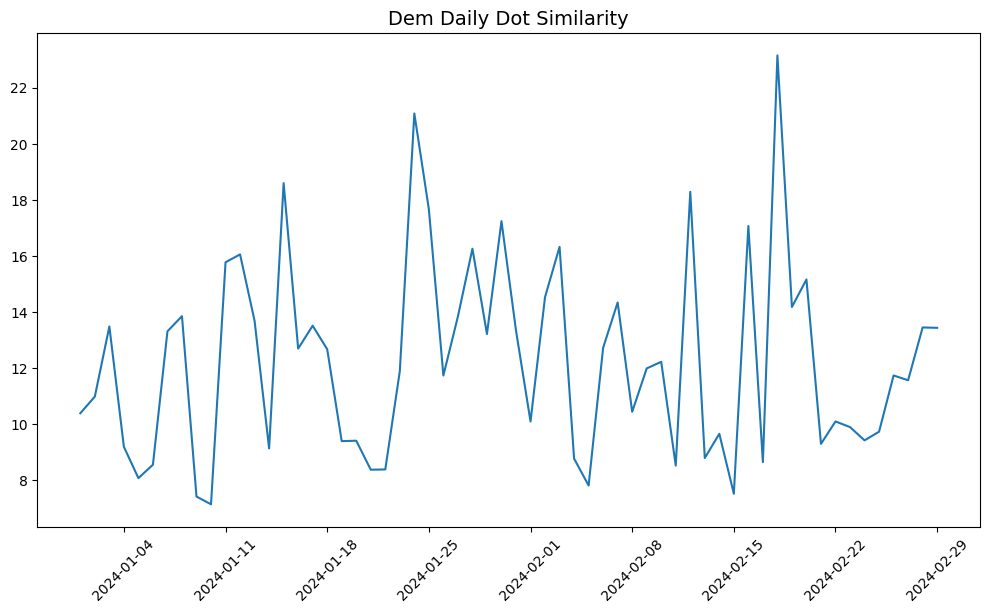

In [203]:
dem_daily_similarity = get_dot_simalirty_by_date(df_dem, df_antonyms, good_bad_dimension)
get_daily_trend(dem_daily_similarity, "Dem Daily Dot Similarity")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  7.44it/s]


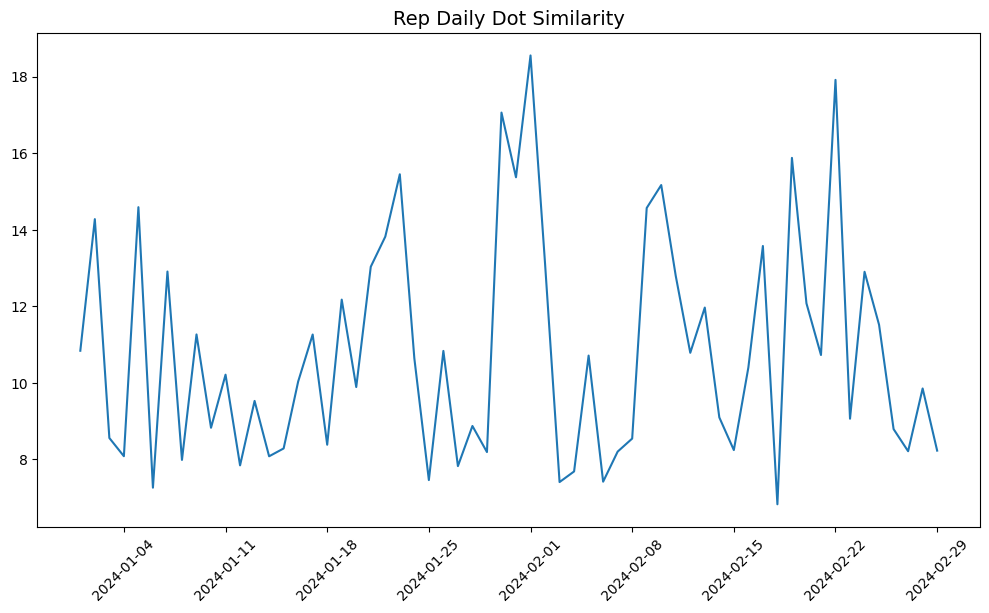

In [204]:
rep_daily_similarity = get_dot_simalirty_by_date(df_rep, df_antonyms, good_bad_dimension)
get_daily_trend(rep_daily_similarity, "Rep Daily Dot Similarity")

In [222]:
all_daily_similarity= [biden_daily_similarity, trump_daily_similarity, dem_daily_similarity, rep_daily_similarity]
color = ["blue", "red", "#75bbfd", "#fed0fc"]

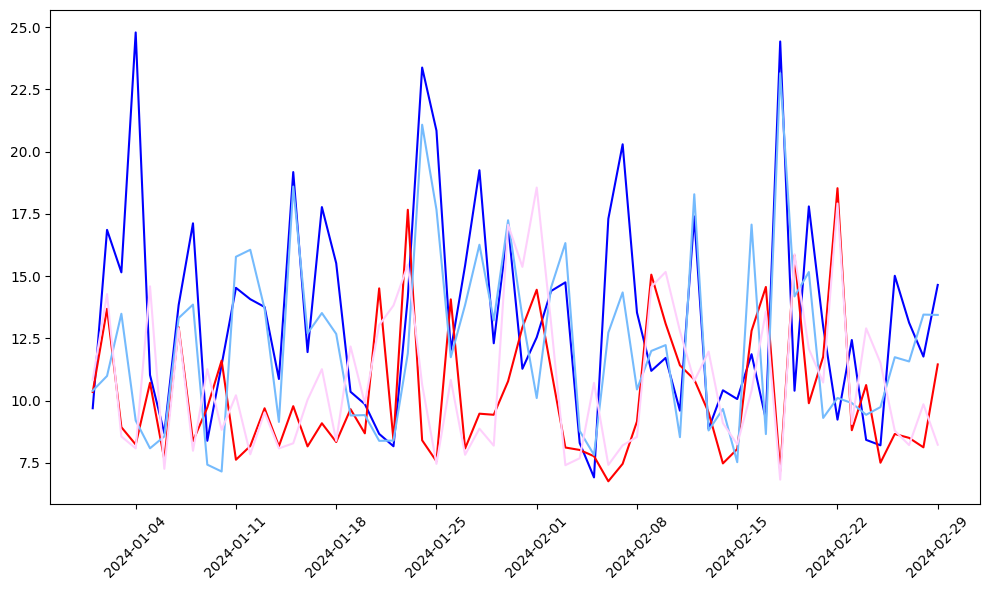

In [223]:
plt.figure(figsize=(10, 6))
for result_list, color in zip(all_daily_similarity, color):
    sns.lineplot(x = [x[0] for x in result_list], y = [x[1] for x in result_list], color=color)

# Set x-axis to only show a label every 7 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Show a tick every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date

plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# plt.title(title, fontsize=14)
plt.show()



In [144]:
# co-occurance sentiment?
# should only focus on major political figures or aggregated analysis  for longitudinal analysis

In [145]:
# combining word space with embedding space

# Good/Bad Dimension Comparsion

In [61]:
# biden similarity
get_cos_similiarity(get_left_to_right_vec(df_biden), good_bad_dimension)

-0.14288598690270757

In [62]:
# Trump similarity
get_cos_similiarity(get_left_to_right_vec(df_trump), good_bad_dimension)

0.051661834852291776

In [63]:
# Dem similarity
get_cos_similiarity(get_left_to_right_vec(df_dem), good_bad_dimension)

-0.11309391119411132

In [64]:
# Rep similarity
get_cos_similiarity(get_left_to_right_vec(df_rep), good_bad_dimension)

0.05532643214926016

In [75]:
# baseline 

base_similarity = []
for i_1 in tqdm(range(len(df_antonyms))):
    for i_2 in range(len(df_antonyms)):
        base_similarity.append(get_cos_similiarity(df_antonyms.iloc[i_1]["adj_1_embedding"], df_antonyms.iloc[i_2]["adj_2_embedding"]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1828/1828 [05:30<00:00,  5.54it/s]


In [78]:
np.array(base_similarity).mean()

0.23902753471356972

In [ ]:
df_antonyms.iloc[0]["adj_1_embedding"]